In [1]:
from google.colab import drive
drive.mount('/content/drive/')
%cd drive/MyDrive/colab_final_project/

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/colab_final_project


In [5]:
!pip install protobuf==3.20.*
!pip install "tensorflow-text==2.8.*" --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobuf-3.19.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.4 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-datasets 4.9.2 requires protobuf>=3.20, but you have protobuf 3.19.6 which is incompatible.
tensorflow-metadata 1.13.1 requires protobuf<5,>=3.20.3, but you have protobuf 3.19.6 which is incompatible.


In [53]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 19.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993224 sha256=8eec6a244f52d29b58bb6a5ef56154a3f506181c95994922ba6c7c4062234550
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [3]:
import re
from itertools import cycle
import json
import urllib.request

import numpy as np
from scipy.sparse import csr_matrix
import pandas as pd

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from wordcloud import WordCloud

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [4]:
train_df = pd.read_csv("https://raw.githubusercontent.com/google-research/google-research/master/goemotions/data/train.tsv", sep='\t', header=None, usecols=[0, 1], names=["Text", "Emotion"])
test_df = pd.read_csv("https://raw.githubusercontent.com/google-research/google-research/master/goemotions/data/test.tsv", sep='\t', header=None, usecols=[0, 1], names=["Text", "Emotion"])
val_df = pd.read_csv("https://raw.githubusercontent.com/google-research/google-research/master/goemotions/data/dev.tsv", sep='\t', header=None, usecols=[0, 1], names=["Text", "Emotion"])

In [5]:
# Downlaod Emotion List and Ekman Mapping

with urllib.request.urlopen('https://raw.githubusercontent.com/google-research/google-research/master/goemotions/data/emotions.txt') as f:
  # Read the contents of the Emotions txt file
  emotion_list = f.read().decode().split("\n")

with urllib.request.urlopen('https://raw.githubusercontent.com/google-research/google-research/master/goemotions/data/ekman_mapping.json') as f:
    # Read the contents of the ekman_mapping json file
    contents = f.read()

    # Parse the JSON data
    ekman_mapping = json.loads(contents)
    ekman_mapping["neutral"] = ["neutral"]

# Reverse the ekman mapping
ekman_dict = {v:k for k, values in ekman_mapping.items() for v in values}

In [6]:
train_df.head()

,Text,Emotion
0,My favourite food is anything I didn't have to...,27
1,"Now if he does off himself, everyone will thin...",27
2,WHY THE FUCK IS BAYLESS ISOING,2
3,To make her feel threatened,14
4,Dirty Southern Wankers,3


In [7]:
def get_emotion(emotion_label):
    """Function to replace emotions labels with the simplified ekamn mapping"""
    emotion_label = emotion_label.split(",")[0]
    emotion = emotion_list[int(emotion_label)]
    # return emotion after ekman mapping
    return ekman_dict[emotion]

train_df["Emotion"] = train_df["Emotion"].apply(get_emotion)
test_df["Emotion"] = test_df["Emotion"].apply(get_emotion)
val_df["Emotion"] = val_df["Emotion"].apply(get_emotion)

In [8]:
train_df.head()

,Text,Emotion
0,My favourite food is anything I didn't have to...,neutral
1,"Now if he does off himself, everyone will thin...",neutral
2,WHY THE FUCK IS BAYLESS ISOING,anger
3,To make her feel threatened,fear
4,Dirty Southern Wankers,anger


In [9]:
train_df = train_df.drop_duplicates("Text")
test_df = test_df.drop_duplicates("Text")
val_df = val_df.drop_duplicates("Text")

In [10]:
def filter_rows_by_values(df, column, value_list):
    """This function filters out rows containing a certian value/values """
    return df[~df[column].isin(value_list)]
train_df = filter_rows_by_values(train_df, "Emotion", ["fear", "disgust"])
test_df = filter_rows_by_values(test_df, "Emotion", ["fear", "disgust"])
val_df = filter_rows_by_values(val_df, "Emotion", ["fear", "disgust"])

In [11]:
oh = preprocessing.OneHotEncoder()
y_train = oh.fit_transform(train_df["Emotion"].values.reshape(-1,1))
y_test = oh.transform(test_df["Emotion"].values.reshape(-1,1))
y_val = oh.transform(val_df["Emotion"].values.reshape(-1,1))

In [12]:
# Convert sparse matrices to tensors so that it can be used for model training

y_train = tf.convert_to_tensor(csr_matrix(y_train).todense(), tf.float32)
y_test = tf.convert_to_tensor(csr_matrix(y_test).todense(), tf.float32)
y_val = tf.convert_to_tensor(csr_matrix(y_val).todense(), tf.float32)

In [13]:
train_ds =  tf.data.Dataset.from_tensor_slices((train_df["Text"], y_train)).shuffle(buffer_size=1000).batch(64)
val_ds =  tf.data.Dataset.from_tensor_slices((val_df["Text"], y_val)).shuffle(buffer_size=1000).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices((test_df["Text"], y_test))

In [14]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Text: {text_batch.numpy()[i]}')
    label = np.argmax(label_batch.numpy()[i])
    print(f'Label : {label} ({oh.categories_[0][label]})')

Text: b'I am more than pleasantly surprised I clicked this link'
Label : 4 (surprise)
Text: b'Your aunt has some damn nerve, though!'
Label : 2 (neutral)
Text: b'I left her off because I tried to keep the list to people who were in a little earlier than her.'
Label : 2 (neutral)


In [15]:
# We will be using the 'ssmall_bert/bert_en_uncased_L-2_H-128_A-2' model

tfhub_handle_encoder = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

In [17]:
def build_bert_model():
  """Function which returns a built model"""

  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
  preprocessor = hub.KerasLayer(
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name='preprocessing')
  encoder_inputs = preprocessor(text_input)
  encoder = hub.KerasLayer(
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2",
        trainable=True,
        name='BERT_encoder')
  outputs = encoder(encoder_inputs)

  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.2)(net)
  net = tf.keras.layers.Dense(32, activation="relu")(net)
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(5, activation="softmax", name='classifier')(net)

  return tf.keras.Model(text_input, net)
model = build_bert_model()

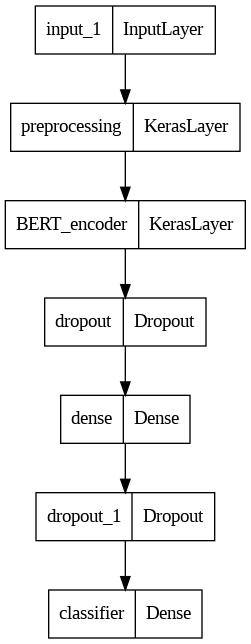

In [18]:
tf.keras.utils.plot_model(model)

In [19]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
loss = tf.keras.losses.CategoricalCrossentropy()
model.compile(optimizer="adam", loss=loss, metrics="accuracy")
history = model.fit(x=train_ds, validation_data=val_ds, epochs=10, callbacks=[early_stopping])

Epoch 1/10
657/657 [==============================] - 802s 1s/step - loss: 1.1295 - accuracy: 0.5663 - val_loss: 0.9736 - val_accuracy: 0.6301
Epoch 2/10
657/657 [==============================] - 785s 1s/step - loss: 0.9954 - accuracy: 0.6285 - val_loss: 0.9969 - val_accuracy: 0.6208
Epoch 3/10
657/657 [==============================] - 762s 1s/step - loss: 0.9399 - accuracy: 0.6463 - val_loss: 0.9529 - val_accuracy: 0.6322
Epoch 4/10
657/657 [==============================] - 777s 1s/step - loss: 0.8701 - accuracy: 0.6738 - val_loss: 0.9785 - val_accuracy: 0.6273
Epoch 5/10
657/657 [==============================] - 777s 1s/step - loss: 0.7940 - accuracy: 0.7035 - val_loss: 1.0198 - val_accuracy: 0.6157
Epoch 6/10
657/657 [==============================] - 774s 1s/step - loss: 0.7203 - accuracy: 0.7304 - val_loss: 1.0836 - val_accuracy: 0.6062


In [20]:
save_path = '/content/drive/MyDrive/colab_final_project/savedModels/TransformerSentiment'
model.save(save_path)

In [21]:
save_path = '/content/drive/MyDrive/colab_final_project/savedModels/TransformerSentimentHDF5.h5'
model.save(save_path)

In [32]:
test_predictions = model.predict(test_df["Text"])
# Get the Single labels from predction instead of an array of probabilities
test_predictions = np.argmax(test_predictions, axis=1)
test_labels = np.argmax(y_test, axis=1)
test_acc = accuracy_score(test_labels, test_predictions)
print(f"Test Accuracy is {test_acc*100}%")

KeyboardInterrupt: ignored

In [24]:
# Classification Report
print(classification_report(test_labels, test_predictions, target_names=oh.categories_[0]))

              precision    recall  f1-score   support

       anger       0.42      0.54      0.47       703
         joy       0.74      0.76      0.75      2049
     neutral       0.58      0.45      0.51      1605
     sadness       0.46      0.46      0.46       317
    surprise       0.49      0.57      0.53       573

    accuracy                           0.60      5247
   macro avg       0.54      0.56      0.54      5247
weighted avg       0.60      0.60      0.60      5247



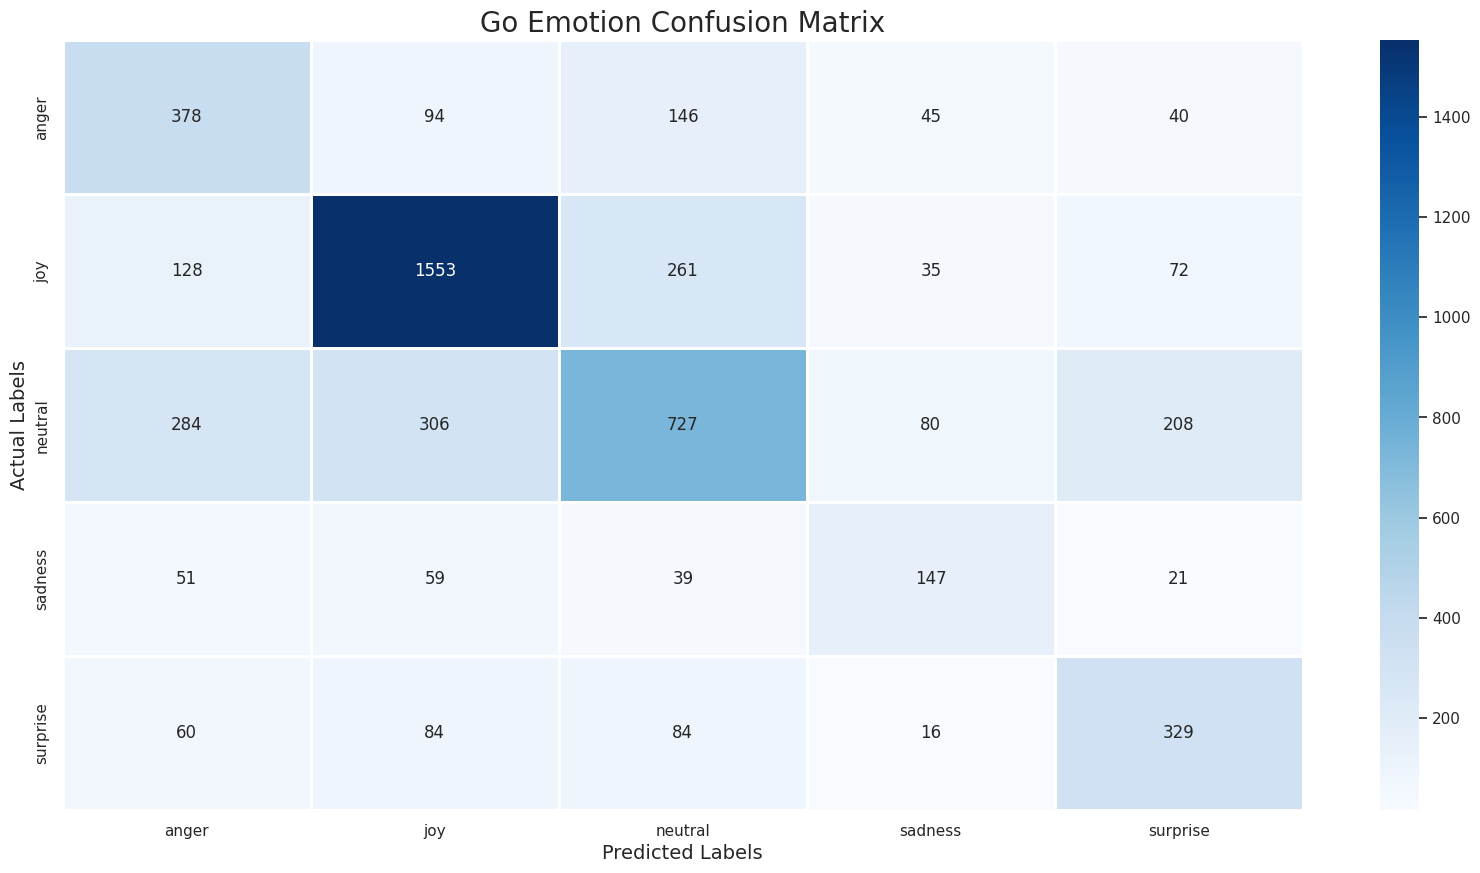

In [25]:
def plot_confusion_matrix(y_test, y_pred, labels=oh.categories_[0]):
    """
    Plot the confusion matrix
    """
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize = (20, 10))
    cm = pd.DataFrame(cm , index = [i for i in labels] , columns = [i for i in labels])
    sns.set(font_scale=1)
    sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
    plt.title('Go Emotion Confusion Matrix', size=20)
    plt.xlabel('Predicted Labels', size=14)
    plt.ylabel('Actual Labels', size=14)
    plt.show()
plot_confusion_matrix( test_labels, test_predictions)

In [59]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')


emoji_dict = {}
with open('emoji.txt', 'r', encoding='latin-1') as emoji_file:
    for line in emoji_file:
        line = line.strip()
        if line:
            emoji, value = line.split('\t')
            emoji_dict[emoji] = int(value)
def replace_emojis(text, emoji_dict):
    for emoji, value in emoji_dict.items():
        if value == 1:
            text = re.sub(re.escape(emoji), 'happy', text)
        elif value == -1:
            text = re.sub(re.escape(emoji), 'sad', text)
    return text
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    words = word_tokenize(text)
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    lemmatizer = WordNetLemmatizer()
    tagged = pos_tag(words)
    words = [lemmatizer.lemmatize(word, pos=get_wordnet_pos(pos)) if get_wordnet_pos(pos) else word for word, pos in tagged]
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [46]:
from google.colab import files
uploaded = files.upload()

Saving firstIter.csv to firstIter (1).csv


In [50]:
import io
input_df = pd.read_csv(io.BytesIO(uploaded['firstIter.csv']))

In [61]:
import random
from langdetect import detect
num_texts = 50  # Number of texts to fetch
testCorpus = []

texts = input_df["Comment Text"].tolist()
random.shuffle(texts)

for text in texts:
    try:
        lang = detect(text)
    except:
        lang = ""
    if lang == "en":
        newText = text.strip()
        newText = replace_emojis(newText, emoji_dict)
        newText = preprocess_text(newText)
        testCorpus.append(newText)
        if len(testCorpus) == num_texts:
            break

testCorpus = pd.Series(testCorpus)

In [66]:
myPredictions = model.predict(testCorpus)
myPredictions = np.argmax(myPredictions, axis=1)

In [67]:
print(myPredictions)

[2 0 2 2 0 2 4 2 2 2 0 2 2 2 2 0 2 1 2 0 2 2 2 2 1 2 2 2 2 2 2 1 2 2 1 2 2
 2 1 1 2 2 2 1 2 0 1 2 4 1]


In [69]:
reverse_mapping = {
    0: ["anger", "annoyance", "disapproval"],
    1: ["disgust"],
    2: ["fear", "nervousness"],
    3: ["joy", "amusement", "approval", "excitement", "gratitude", "love", "optimism", "relief", "pride", "admiration", "desire", "caring"],
    4: ["sadness", "disappointment", "embarrassment", "grief", "remorse"],
    5: ["surprise", "realization", "confusion", "curiosity"],
    6: ["neutral"]
}
predicted_emotions = [reverse_mapping[prediction] for prediction in myPredictions]
predicted_emotions

[['fear', 'nervousness'],
 ['anger', 'annoyance', 'disapproval'],
 ['fear', 'nervousness'],
 ['fear', 'nervousness'],
 ['anger', 'annoyance', 'disapproval'],
 ['fear', 'nervousness'],
 ['sadness', 'disappointment', 'embarrassment', 'grief', 'remorse'],
 ['fear', 'nervousness'],
 ['fear', 'nervousness'],
 ['fear', 'nervousness'],
 ['anger', 'annoyance', 'disapproval'],
 ['fear', 'nervousness'],
 ['fear', 'nervousness'],
 ['fear', 'nervousness'],
 ['fear', 'nervousness'],
 ['anger', 'annoyance', 'disapproval'],
 ['fear', 'nervousness'],
 ['disgust'],
 ['fear', 'nervousness'],
 ['anger', 'annoyance', 'disapproval'],
 ['fear', 'nervousness'],
 ['fear', 'nervousness'],
 ['fear', 'nervousness'],
 ['fear', 'nervousness'],
 ['disgust'],
 ['fear', 'nervousness'],
 ['fear', 'nervousness'],
 ['fear', 'nervousness'],
 ['fear', 'nervousness'],
 ['fear', 'nervousness'],
 ['fear', 'nervousness'],
 ['disgust'],
 ['fear', 'nervousness'],
 ['fear', 'nervousness'],
 ['disgust'],
 ['fear', 'nervousness'],

In [70]:
!pip freeze > requirements.txt